## Motivating Example for Vector Optimization and VOPy
This notebook contains a basic example that motivates a vector optimization solution in two-dimensional Euclidean space, followed by what VOPy offers while other SOTA black-box optimization libraries lack. Let's start by getting our imports out of the way.

In [1]:
import numpy as np
import torch
import botorch.utils.multi_objective.pareto

from vopy.order import ConeTheta2DOrder
from vopy.ordering_cone import ConeTheta2D
from vopy.datasets import get_dataset_instance

from vopy.utils.plotting import plot_pareto_front

#### Pareto points and domination
Let's create an instance of a test dataset that has two objectives that we try to maximize. Assume we're trying to find the best candy possible between several candidates whose objectives are cheapness and taste. We can calculate its [Pareto front](https://en.wikipedia.org/wiki/Pareto_front) using a popular Bayesian optimization tool called BoTorch, and visualize it. Any other library that does the same job would do just fine. Remember that cheapness would correspond to the $x$-axis and the taste would correspond to the $y$-axis.

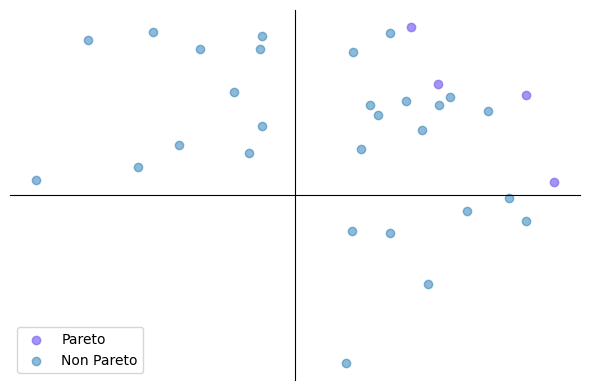

In [ ]:
dataset_name = "Test"
dataset = get_dataset_instance(dataset_name)
pareto_front = botorch.utils.multi_objective.pareto.is_non_dominated(torch.tensor(dataset.out_data))
fig_pareto = plot_pareto_front(dataset.out_data, pareto_indices=pareto_front)

As you can see, there are multiple candidates (the 4 purple dots) in our Pareto front that can not be compared with each other. Some have higher cheapness but lower taste while others are more expensive but they taste better.

In most problems that have multiple objectives, similar to our case, several candidates are constituting the Pareto front. These are selected so as not to be "dominated" by any other candidate in any of the objectives. While the selection we visualized is valid, it reflects only a specific domination definition we are all familiar with, specifically the $\leq$ ordering. We'll call this the componentwise order for obvious reasons. The field working on this kind of optimization is called **multi-objective optimization**. We can examine this componentwise order and its domination relation within a generalized framework, *i.e.*, cones, by observing the following: a candidate belongs to the Pareto front if no other candidate is inside the first quadrant of a coordinate system that has the candidate as its origin. This is equivalent to the difference vector between candidates being inside the first quadrant of the Cartesian coordinate system. In the figure below, you can see this specific region traced. This region can be represented with a convex polyhedral cone.* We can then define the domination according to the cone we have, by checking the difference vector w.r.t. the cone instead of a simple $\leq$. Why bother you may ask, please bear with me.

*\*: If you examine the code below, you can see that it is represented as a cone using VOPy. It is a special kind of cone as well, but let's not get ahead of ourselves.*

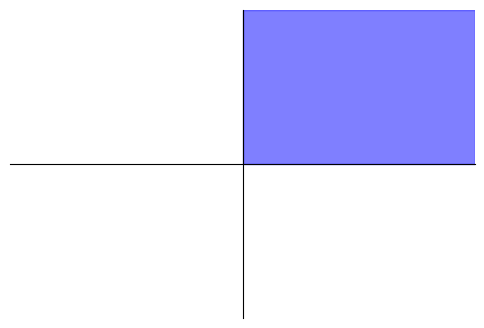

In [7]:
componentwise_angle_around_x_equal_y = np.rad2deg(np.pi/2)
componentwise_2d_ordering_cone = ConeTheta2D(cone_degree=componentwise_angle_around_x_equal_y)
_ = componentwise_2d_ordering_cone.plot()

#### Preferences?
At this point, the following question might arise: "Can we somehow encode preferences using this approach?". The answer is a clear yes. We will work through an example.

Let's say we would like to allow a tradeoff between our objectives, and say for example a decrease in cheapness is tolerable if we gain 2 times as much in taste. Let's say this tradeoff is symmetrical for practical purposes, meaning it is also valid for a decrease in taste and an increase in cheapness. So, the cone for this region would have to be a bit wider on both axes, like the following.

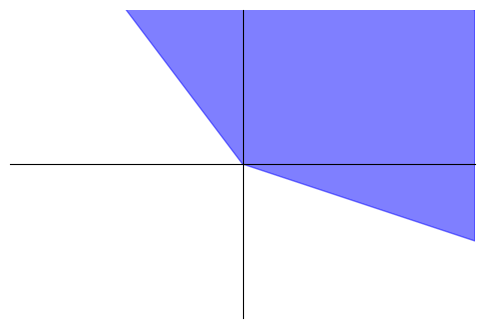

In [8]:
trade_off_ratio = 1/2
obtuse_angle_around_x_equal_y = np.rad2deg(np.pi/2 + 2*np.arctan(trade_off_ratio))
obtuse_2d_ordering_cone = ConeTheta2D(cone_degree=obtuse_angle_around_x_equal_y)
_ = obtuse_2d_ordering_cone.plot()

Notice that, for example, the difference vector of $(3, -0.1)$ would be in this cone, unlike the cone for the componentwise order. This means we would still consider 3 units increase in cheapness but 0.1 units decrease in taste domination.

OK. Now that we have defined how we want to choose our "best" candidates using a cone, allowing some tradeoff between objectives, we should find which candies are Pareto\* w.r.t. our preferences. Can we use the same function from BoTorch? Unfortunately, we can't. This is where **vector optimization** comes into play. It allows us to optimize functions considering the preferences defined by a cone. Cones like ours induce partial orderings (*e.g.* componentwise order), which can resolve domination relations that we've talked about and tell us which candidate is better.

VOPy is needed at this point, as no other black-box optimization library currently supports this. VOPy gives the user the ability to define partial orderings and optimize the function at hand using these orderings. Let's find our best candies using the cone we created above with VOPy.

\**: Note that Pareto optimality is originally defined for the componentwise order. We call the best candidates under different partial orderings Pareto optimal as well, noting the cone that is being considered.*

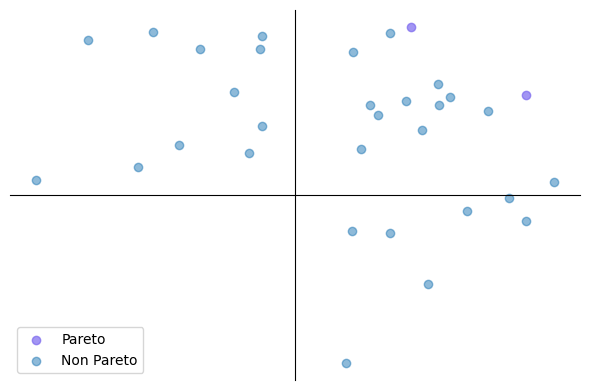

In [9]:
obtuse_2d_order = ConeTheta2DOrder(cone_degree=obtuse_angle_around_x_equal_y)
_ = obtuse_2d_order.plot_pareto_set(dataset.out_data)

As our preference allowed some tradeoffs, it's easier to compare candidates, and being the best is thus harder. Two previous candidates were eliminated because they were providing small benefits on one objective but they were too bad on the other objective. We now have only 2 candidate candies at hand. Sweet!

#### Black-box Vector Optimization?
Until now, we assumed known function values, so we knew the taste and cheapness of all candies before starting our optimization procedure. If we didn't know the function, and the only information that we could get was the noisy function evaluations by querying some candidates, we would have to deal with black-box optimization. That's where things get more complicated and why we need a library like VOPy. VOPy specializes in providing black-box vector optimization algorithms and an environment for the development of black-box vector optimization algorithms. To see a scientific application of black-box vector optimization (with a preference cone) on a real-world ML fairness dataset, you can see [this another example](06_naive_el_vs_paveba_on_fairness.ipynb).